# 00. 라이브러리 로드

In [56]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

import keras

2.6.0
1.21.4


# 01. ResNet Model 설계

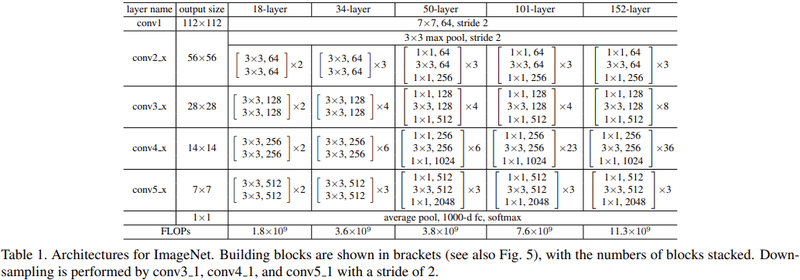

### 01_1. ResNet block

In [38]:
def build_resnet_block(x, filters, blocks, stride=1, is_plain=False, is_50=False):

    expansion = 4 if is_50 else 1

    for i in range(blocks):
        stride_current = stride if i == 0 else 1
        shortcut = x

        if is_50:
            # Bottleneck 블록
            x = keras.layers.Conv2D(filters, kernel_size=1, strides=stride_current, padding='same',
                                    kernel_initializer='he_normal')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)

            x = keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same',
                                    kernel_initializer='he_normal')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)

            x = keras.layers.Conv2D(filters * expansion, kernel_size=1, strides=1, padding='same',
                                    kernel_initializer='he_normal')(x)
            x = keras.layers.BatchNormalization()(x)
        else:
            # Basic 블록
            x = keras.layers.Conv2D(filters, kernel_size=3, strides=stride_current, padding='same',
                                    kernel_initializer='he_normal')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)

            x = keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same',
                                    kernel_initializer='he_normal')(x)
            x = keras.layers.BatchNormalization()(x)

        if not is_plain:
            if stride_current != 1 or keras.backend.int_shape(shortcut)[-1] != filters * expansion:
                shortcut = keras.layers.Conv2D(filters * expansion, kernel_size=1, strides=stride_current,
                                               padding='same', kernel_initializer='he_normal')(shortcut)
                shortcut = keras.layers.BatchNormalization()(shortcut)
            x = keras.layers.Add()([x, shortcut])

        x = keras.layers.Activation('relu')(x)

    return x

### 01_2. ResNet Build

In [39]:
def build_resnet(input_shape, num_classes, is_50=False, is_plain=False):

    inputs = keras.layers.Input(shape=input_shape)

    # 초기 레이어
    x = keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same',
                            kernel_initializer='he_normal',name='input layer')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    if is_50:
        # ResNet-50 설정
        layers = [3, 4, 6, 3]
        filters = [64, 128, 256, 512]
    else:
        # ResNet-34 설정
        layers = [3, 4, 6, 3]
        filters = [64, 128, 256, 512]

    # 각 스테이지별로 블록을 쌓습니다.
    for i in range(len(layers)):
        stride = 1 if i == 0 else 2
        x = build_resnet_block(x, filters=filters[i], blocks=layers[i], stride=stride,
                               is_plain=is_plain, is_50=is_50)

    # 최종 레이어
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, activation='softmax')(x)

    # 모델 이름 설정
    model_depth = 50 if is_50 else 34
    model_type = 'plainnet' if is_plain else 'resnet'
    model_name = f"{model_type}_{model_depth}"

    model = keras.models.Model(inputs=inputs, outputs=x, name=model_name)

    return model

### 01_3. PlainNet Build 

In [40]:
def build_plainnet(input_shape, num_classes, is_50=False):

    return build_resnet(input_shape, num_classes, is_50=is_50, is_plain=True)

### 01_4. config 

In [49]:
input_shape = (224,224,3)
num_classes = 2

# 02. Complete Model 

### 02_1. ResNet 34

In [50]:
# ResNet-34
resnet34 = build_resnet(input_shape=input_shape, num_classes=num_classes, is_50=False, is_plain=False)
resnet34.summary()


Model: "resnet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_641 (Conv2D)             (None, 112, 112, 64) 9472        input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_645 (BatchN (None, 112, 112, 64) 256         conv2d_641[0][0]                 
__________________________________________________________________________________________________
activation_629 (Activation)     (None, 112, 112, 64) 0           batch_normalization_645[0][0]    
__________________________________________________________________________________________

### 02_2. ResNet 50

In [51]:
# ResNet-50
resnet50 = build_resnet(input_shape=input_shape, num_classes=num_classes, is_50=True, is_plain=False)
resnet50.summary()



Model: "resnet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_677 (Conv2D)             (None, 112, 112, 64) 9472        input_16[0][0]                   
__________________________________________________________________________________________________
batch_normalization_681 (BatchN (None, 112, 112, 64) 256         conv2d_677[0][0]                 
__________________________________________________________________________________________________
activation_662 (Activation)     (None, 112, 112, 64) 0           batch_normalization_681[0][0]    
__________________________________________________________________________________________

### 02_3. PlainNet 34

In [52]:
# PlainNet-34
plainnet34 = build_plainnet(input_shape=input_shape, num_classes=num_classes, is_50=False)
plainnet34.summary()

Model: "plainnet_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_730 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_734 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_711 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_731 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_735 (Bat (None, 56, 56, 64)        

### 02_4. PlainNet 50

In [53]:
# PlainNet-50
plainnet50 = build_plainnet(input_shape=input_shape, num_classes=num_classes, is_50=True)
plainnet50.summary()

Model: "plainnet_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_763 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_767 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_744 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_764 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_768 (Bat (None, 56, 56, 64)        

# 실험 진행

In [58]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# 다운로드 URL 업데이트
setattr(tfds.image_classification.cats_vs_dogs, '_URL',
        "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

# 1. 데이터셋 로드
(raw_train, raw_validation), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [59]:
# 2. 데이터 전처리 함수 정의
IMG_SIZE = (224, 224)  # ResNet 모델의 입력 크기

def format_example(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

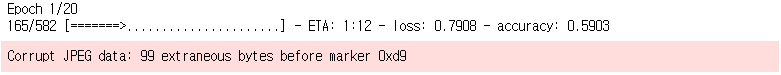

### JPEG 오류로 인한 위 이미지 오류 -> 발생 개수의 변동이 생기긴 하나 예외처리 함수 적용

In [ ]:
def decode_image(image, label):
    try:
        image = tf.image.resize(image, IMG_SIZE)
        image = image / 255.0
        return image, label
    except tf.errors.InvalidArgumentError:
        return None


In [60]:
# 3. 데이터셋에 전처리 적용
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000


train = raw_train.map(lambda x, y: decode_image(x, y)).filter(lambda x: x is not None)
validation = raw_validation.map(lambda x, y: decode_image(x, y)).filter(lambda x: x is not None)

train = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation = validation.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [62]:
# 4. 모델 생성

input_shape = (224,224,3)
num_classes = 2

resnet34 = build_resnet(input_shape=input_shape, num_classes=num_classes, is_50=False, is_plain=False)

resnet50 = build_resnet(input_shape=input_shape, num_classes=num_classes, is_50=True, is_plain=False)

plainnet34 = build_plainnet(input_shape=input_shape, num_classes=num_classes, is_50=False)

plainnet50 = build_plainnet(input_shape=input_shape, num_classes=num_classes, is_50=True)

In [63]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam()

# 모델 컴파일
resnet34.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
resnet50.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
plainnet34.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
plainnet50.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [64]:
EPOCHS = 20

# 학습 손실을 저장할 딕셔너리 초기화
history_dict = {}

# resnet34 학습
history_resnet34 = resnet34.fit(
    train,
    validation_data=validation,
    epochs=EPOCHS
)
history_dict['resnet34'] = history_resnet34.history

# resnet50 학습
history_resnet50 = resnet50.fit(
    train,
    validation_data=validation,
    epochs=EPOCHS
)
history_dict['resnet50'] = history_resnet50.history

# plainnet34 학습
history_plainnet34 = plainnet34.fit(
    train,
    validation_data=validation,
    epochs=EPOCHS
)
history_dict['plainnet34'] = history_plainnet34.history

# plainnet50 학습
history_plainnet50 = plainnet50.fit(
    train,
    validation_data=validation,
    epochs=EPOCHS
)
history_dict['plainnet50'] = history_plainnet50.history

Epoch 1/20
165/582 [=======>......................] - ETA: 1:12 - loss: 0.7908 - accuracy: 0.5903

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:06 - loss: 0.7755 - accuracy: 0.5925

208/582 [=========>....................] - ETA: 1:05 - loss: 0.7673 - accuracy: 0.5968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 52s - loss: 0.7439 - accuracy: 0.6040

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.6989 - accuracy: 0.6219

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.6973 - accuracy: 0.6231

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.6958 - accuracy: 0.6240

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6898 - accuracy: 0.6291

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6890 - accuracy: 0.6296

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6840 - accuracy: 0.6320

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 193ms/step - loss: 0.6840 - accuracy: 0.6320 - val_loss: 0.6966 - val_accuracy: 0.6552
Epoch 2/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.5989 - accuracy: 0.6847

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.5950 - accuracy: 0.6892

208/582 [=========>....................] - ETA: 1:06 - loss: 0.5933 - accuracy: 0.6899

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.5814 - accuracy: 0.6993

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.5602 - accuracy: 0.7173

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.5589 - accuracy: 0.7181

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.5577 - accuracy: 0.7190

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.5525 - accuracy: 0.7225

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.5517 - accuracy: 0.7231

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5502 - accuracy: 0.7248

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.5502 - accuracy: 0.7248 - val_loss: 0.8210 - val_accuracy: 0.5550
Epoch 3/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.4815 - accuracy: 0.7714

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.4817 - accuracy: 0.7716

208/582 [=========>....................] - ETA: 1:06 - loss: 0.4828 - accuracy: 0.7727

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.4809 - accuracy: 0.7748

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.4724 - accuracy: 0.7788

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.4714 - accuracy: 0.7799

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.4709 - accuracy: 0.7798

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.4681 - accuracy: 0.7812

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.4668 - accuracy: 0.7819

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4638 - accuracy: 0.7839

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.4638 - accuracy: 0.7839 - val_loss: 1.1080 - val_accuracy: 0.5043
Epoch 4/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.4291 - accuracy: 0.8062

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.4266 - accuracy: 0.8090

208/582 [=========>....................] - ETA: 1:06 - loss: 0.4238 - accuracy: 0.8102

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.4197 - accuracy: 0.8124

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.4021 - accuracy: 0.8193

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.4010 - accuracy: 0.8197

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.3996 - accuracy: 0.8206

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.3964 - accuracy: 0.8222

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.3952 - accuracy: 0.8229

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3929 - accuracy: 0.8233

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 191ms/step - loss: 0.3929 - accuracy: 0.8233 - val_loss: 0.9121 - val_accuracy: 0.5331
Epoch 5/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.3584 - accuracy: 0.8502

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.3551 - accuracy: 0.8497

208/582 [=========>....................] - ETA: 1:06 - loss: 0.3545 - accuracy: 0.8489

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.3485 - accuracy: 0.8503

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.3281 - accuracy: 0.8580

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.3268 - accuracy: 0.8588

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.3250 - accuracy: 0.8596

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.3213 - accuracy: 0.8614

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.3213 - accuracy: 0.8612

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3198 - accuracy: 0.8621

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 115s 196ms/step - loss: 0.3198 - accuracy: 0.8621 - val_loss: 0.3330 - val_accuracy: 0.8667
Epoch 6/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.2731 - accuracy: 0.8873

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.2682 - accuracy: 0.8895

208/582 [=========>....................] - ETA: 1:06 - loss: 0.2681 - accuracy: 0.8899

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.2676 - accuracy: 0.8886

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.2585 - accuracy: 0.8930

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.2590 - accuracy: 0.8930

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.2573 - accuracy: 0.8939

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.2558 - accuracy: 0.8943

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.2554 - accuracy: 0.8945

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2541 - accuracy: 0.8948

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.2541 - accuracy: 0.8948 - val_loss: 0.3553 - val_accuracy: 0.8399
Epoch 7/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.2293 - accuracy: 0.9055

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.2220 - accuracy: 0.9081

208/582 [=========>....................] - ETA: 1:06 - loss: 0.2204 - accuracy: 0.9081

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.2153 - accuracy: 0.9105

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.2112 - accuracy: 0.9126

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.2103 - accuracy: 0.9129

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.2099 - accuracy: 0.9124

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.2106 - accuracy: 0.9118

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.2100 - accuracy: 0.9119

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.9130

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.2077 - accuracy: 0.9130 - val_loss: 0.2593 - val_accuracy: 0.8914
Epoch 8/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.1899 - accuracy: 0.9258

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.1941 - accuracy: 0.9244

208/582 [=========>....................] - ETA: 1:06 - loss: 0.1926 - accuracy: 0.9246

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.1888 - accuracy: 0.9263

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.1854 - accuracy: 0.9271

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.1857 - accuracy: 0.9270

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.1858 - accuracy: 0.9266

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1833 - accuracy: 0.9274

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1832 - accuracy: 0.9272

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1825 - accuracy: 0.9272

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.1825 - accuracy: 0.9272 - val_loss: 0.4033 - val_accuracy: 0.8338
Epoch 9/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.1731 - accuracy: 0.9288

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.1684 - accuracy: 0.9309

208/582 [=========>....................] - ETA: 1:06 - loss: 0.1674 - accuracy: 0.9309

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.1706 - accuracy: 0.9282

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.1642 - accuracy: 0.9329

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.1635 - accuracy: 0.9337

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.1625 - accuracy: 0.9341

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1616 - accuracy: 0.9348

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1623 - accuracy: 0.9343

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.9348

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.1608 - accuracy: 0.9348 - val_loss: 0.3164 - val_accuracy: 0.8938
Epoch 10/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.1469 - accuracy: 0.9420

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.1432 - accuracy: 0.9430

208/582 [=========>....................] - ETA: 1:06 - loss: 0.1435 - accuracy: 0.9431

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.1443 - accuracy: 0.9411

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.1440 - accuracy: 0.9420

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.1439 - accuracy: 0.9422

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.1427 - accuracy: 0.9426

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1422 - accuracy: 0.9428

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1424 - accuracy: 0.9429

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 0.9434

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.1410 - accuracy: 0.9434 - val_loss: 0.1929 - val_accuracy: 0.9230
Epoch 11/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.1358 - accuracy: 0.9428

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.1373 - accuracy: 0.9432

208/582 [=========>....................] - ETA: 1:06 - loss: 0.1364 - accuracy: 0.9438

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.1314 - accuracy: 0.9462

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.1310 - accuracy: 0.9470

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.1300 - accuracy: 0.9475

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.1301 - accuracy: 0.9477

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1302 - accuracy: 0.9478

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1302 - accuracy: 0.9476

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.9484

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.1288 - accuracy: 0.9484 - val_loss: 0.4474 - val_accuracy: 0.7971
Epoch 12/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.1249 - accuracy: 0.9489

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.1218 - accuracy: 0.9493

208/582 [=========>....................] - ETA: 1:06 - loss: 0.1208 - accuracy: 0.9495

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.1160 - accuracy: 0.9503

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.1100 - accuracy: 0.9554

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.1096 - accuracy: 0.9555

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.1093 - accuracy: 0.9555

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1096 - accuracy: 0.9554

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1098 - accuracy: 0.9554

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1112 - accuracy: 0.9545

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.1112 - accuracy: 0.9545 - val_loss: 0.2172 - val_accuracy: 0.9101
Epoch 13/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0973 - accuracy: 0.9604

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0952 - accuracy: 0.9610

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0981 - accuracy: 0.9597

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.1016 - accuracy: 0.9577

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.1005 - accuracy: 0.9596

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.1011 - accuracy: 0.9591

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.1003 - accuracy: 0.9595

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0988 - accuracy: 0.9601

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0984 - accuracy: 0.9602

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0971 - accuracy: 0.9608

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0971 - accuracy: 0.9608 - val_loss: 0.4213 - val_accuracy: 0.8523
Epoch 14/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0954 - accuracy: 0.9614

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0911 - accuracy: 0.9631

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0927 - accuracy: 0.9626

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0878 - accuracy: 0.9653

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0832 - accuracy: 0.9670

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0828 - accuracy: 0.9672

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0823 - accuracy: 0.9675

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0812 - accuracy: 0.9678

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0813 - accuracy: 0.9678

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.9681

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0814 - accuracy: 0.9681 - val_loss: 0.1878 - val_accuracy: 0.9258
Epoch 15/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0788 - accuracy: 0.9669

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0795 - accuracy: 0.9675

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0783 - accuracy: 0.9680

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0770 - accuracy: 0.9690

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0745 - accuracy: 0.9696

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0751 - accuracy: 0.9692

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0754 - accuracy: 0.9690

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0747 - accuracy: 0.9694

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0744 - accuracy: 0.9696

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0745 - accuracy: 0.9697

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 192ms/step - loss: 0.0745 - accuracy: 0.9697 - val_loss: 0.2908 - val_accuracy: 0.9041
Epoch 16/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0723 - accuracy: 0.9718

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0715 - accuracy: 0.9717

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0725 - accuracy: 0.9716

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0700 - accuracy: 0.9719

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0625 - accuracy: 0.9756

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0627 - accuracy: 0.9754

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0635 - accuracy: 0.9752

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0636 - accuracy: 0.9753

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0642 - accuracy: 0.9751

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0645 - accuracy: 0.9751

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0645 - accuracy: 0.9751 - val_loss: 0.2159 - val_accuracy: 0.9175
Epoch 17/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0564 - accuracy: 0.9780

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0535 - accuracy: 0.9787

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0530 - accuracy: 0.9788

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0532 - accuracy: 0.9791

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0510 - accuracy: 0.9798

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0516 - accuracy: 0.9795

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0518 - accuracy: 0.9794

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0514 - accuracy: 0.9797

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0512 - accuracy: 0.9799

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0500 - accuracy: 0.9802

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0500 - accuracy: 0.9802 - val_loss: 0.1830 - val_accuracy: 0.9310
Epoch 18/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0495 - accuracy: 0.9826

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0498 - accuracy: 0.9812

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0505 - accuracy: 0.9814

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0500 - accuracy: 0.9808

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0449 - accuracy: 0.9831

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0452 - accuracy: 0.9830

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0452 - accuracy: 0.9830

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0451 - accuracy: 0.9832

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0452 - accuracy: 0.9831

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.9828

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0458 - accuracy: 0.9828 - val_loss: 0.6313 - val_accuracy: 0.8472
Epoch 19/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0456 - accuracy: 0.9822

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0455 - accuracy: 0.9822

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0443 - accuracy: 0.9827

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0453 - accuracy: 0.9833

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0394 - accuracy: 0.9854

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0397 - accuracy: 0.9855

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0399 - accuracy: 0.9852

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0395 - accuracy: 0.9854

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0393 - accuracy: 0.9855

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 0.9850

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.0403 - accuracy: 0.9850 - val_loss: 0.4169 - val_accuracy: 0.8478
Epoch 20/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0452 - accuracy: 0.9826

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0464 - accuracy: 0.9822

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0455 - accuracy: 0.9827

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0437 - accuracy: 0.9834

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0412 - accuracy: 0.9848

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0409 - accuracy: 0.9848

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0405 - accuracy: 0.9849

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0393 - accuracy: 0.9854

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0395 - accuracy: 0.9855

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9859

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 192ms/step - loss: 0.0387 - accuracy: 0.9859 - val_loss: 0.3165 - val_accuracy: 0.9101
Epoch 1/20
164/582 [=======>......................] - ETA: 2:14 - loss: 1.0722 - accuracy: 0.5391

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 1.0139 - accuracy: 0.5495

207/582 [=========>....................] - ETA: 2:01 - loss: 1.0038 - accuracy: 0.5531

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.9327 - accuracy: 0.5569

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.8277 - accuracy: 0.5775

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.8244 - accuracy: 0.5784

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.8200 - accuracy: 0.5796

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.8105 - accuracy: 0.5843

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.8086 - accuracy: 0.5850

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7993 - accuracy: 0.5863

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 211s 349ms/step - loss: 0.7993 - accuracy: 0.5863 - val_loss: 0.6564 - val_accuracy: 0.6199
Epoch 2/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.6357 - accuracy: 0.6515

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.6320 - accuracy: 0.6526

207/582 [=========>....................] - ETA: 2:00 - loss: 0.6314 - accuracy: 0.6535

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.6290 - accuracy: 0.6552

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.6242 - accuracy: 0.6597

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.6238 - accuracy: 0.6603

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.6236 - accuracy: 0.6613

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.6204 - accuracy: 0.6639

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.6209 - accuracy: 0.6635

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6192 - accuracy: 0.6651

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.6192 - accuracy: 0.6651 - val_loss: 0.7665 - val_accuracy: 0.5718
Epoch 3/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.5881 - accuracy: 0.6951

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.5823 - accuracy: 0.7010

207/582 [=========>....................] - ETA: 2:01 - loss: 0.5862 - accuracy: 0.7000

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.5772 - accuracy: 0.7062

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.5657 - accuracy: 0.7161

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.5640 - accuracy: 0.7172

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.5641 - accuracy: 0.7178

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.5636 - accuracy: 0.7188

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.5632 - accuracy: 0.7189

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5597 - accuracy: 0.7214

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.5597 - accuracy: 0.7214 - val_loss: 0.8308 - val_accuracy: 0.6053
Epoch 4/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.5298 - accuracy: 0.7426

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.5275 - accuracy: 0.7437

207/582 [=========>....................] - ETA: 2:01 - loss: 0.5274 - accuracy: 0.7434

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.5249 - accuracy: 0.7487

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.5149 - accuracy: 0.7546

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.5163 - accuracy: 0.7536

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.5145 - accuracy: 0.7545

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.5122 - accuracy: 0.7554

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.5116 - accuracy: 0.7560

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5099 - accuracy: 0.7577

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 346ms/step - loss: 0.5099 - accuracy: 0.7577 - val_loss: 0.8925 - val_accuracy: 0.6058
Epoch 5/20
164/582 [=======>......................] - ETA: 2:15 - loss: 0.4808 - accuracy: 0.7788

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.4753 - accuracy: 0.7809

207/582 [=========>....................] - ETA: 2:01 - loss: 0.4738 - accuracy: 0.7817

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.4737 - accuracy: 0.7816

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.4613 - accuracy: 0.7883

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.4612 - accuracy: 0.7887

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.4605 - accuracy: 0.7890

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.4580 - accuracy: 0.7907

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.4580 - accuracy: 0.7908

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4572 - accuracy: 0.7903

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 203s 346ms/step - loss: 0.4572 - accuracy: 0.7903 - val_loss: 1.0234 - val_accuracy: 0.5252
Epoch 6/20
164/582 [=======>......................] - ETA: 2:15 - loss: 0.4336 - accuracy: 0.8054

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.4545 - accuracy: 0.7935

207/582 [=========>....................] - ETA: 2:01 - loss: 0.4593 - accuracy: 0.7897

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.4716 - accuracy: 0.7835

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.4574 - accuracy: 0.7911

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.4578 - accuracy: 0.7907

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.4565 - accuracy: 0.7915

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.4559 - accuracy: 0.7918

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.4552 - accuracy: 0.7922

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4500 - accuracy: 0.7949

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 346ms/step - loss: 0.4500 - accuracy: 0.7949 - val_loss: 0.5881 - val_accuracy: 0.7468
Epoch 7/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.4037 - accuracy: 0.8236

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.3982 - accuracy: 0.8284

207/582 [=========>....................] - ETA: 2:00 - loss: 0.3975 - accuracy: 0.8280

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.3912 - accuracy: 0.8301

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.3797 - accuracy: 0.8349

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.3800 - accuracy: 0.8348

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.3791 - accuracy: 0.8349

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.3795 - accuracy: 0.8346

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.3789 - accuracy: 0.8350

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3770 - accuracy: 0.8364

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 346ms/step - loss: 0.3770 - accuracy: 0.8364 - val_loss: 0.6210 - val_accuracy: 0.7242
Epoch 8/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.3377 - accuracy: 0.8588

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.3404 - accuracy: 0.8552

207/582 [=========>....................] - ETA: 2:00 - loss: 0.3403 - accuracy: 0.8555

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.3362 - accuracy: 0.8571

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.3279 - accuracy: 0.8622

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.3262 - accuracy: 0.8627

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.3253 - accuracy: 0.8631

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.3255 - accuracy: 0.8626

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.3250 - accuracy: 0.8629

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3238 - accuracy: 0.8627

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.3238 - accuracy: 0.8627 - val_loss: 0.9063 - val_accuracy: 0.7206
Epoch 9/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.2928 - accuracy: 0.8714

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.2944 - accuracy: 0.8702

207/582 [=========>....................] - ETA: 2:01 - loss: 0.2942 - accuracy: 0.8711

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.2935 - accuracy: 0.8726

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.2818 - accuracy: 0.8792

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.2812 - accuracy: 0.8799

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.2806 - accuracy: 0.8798

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.2796 - accuracy: 0.8803

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.2793 - accuracy: 0.8803

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2809 - accuracy: 0.8795

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.2809 - accuracy: 0.8795 - val_loss: 0.3525 - val_accuracy: 0.8364
Epoch 10/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.2544 - accuracy: 0.8942

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.2582 - accuracy: 0.8910

207/582 [=========>....................] - ETA: 2:01 - loss: 0.2592 - accuracy: 0.8904

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.2537 - accuracy: 0.8924

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.2487 - accuracy: 0.8960

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.2485 - accuracy: 0.8958

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.2481 - accuracy: 0.8962

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.2476 - accuracy: 0.8956

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.2484 - accuracy: 0.8953

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2486 - accuracy: 0.8945

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.2486 - accuracy: 0.8945 - val_loss: 1.3176 - val_accuracy: 0.5404
Epoch 11/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.2291 - accuracy: 0.9049

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.2298 - accuracy: 0.9039

207/582 [=========>....................] - ETA: 2:01 - loss: 0.2340 - accuracy: 0.9025

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.2260 - accuracy: 0.9060

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.2219 - accuracy: 0.9080

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.2237 - accuracy: 0.9078

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.2247 - accuracy: 0.9072

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.2238 - accuracy: 0.9074

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.2236 - accuracy: 0.9076

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2198 - accuracy: 0.9089

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.2198 - accuracy: 0.9089 - val_loss: 0.3313 - val_accuracy: 0.8749
Epoch 12/20
164/582 [=======>......................] - ETA: 2:15 - loss: 0.2000 - accuracy: 0.9209

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.2009 - accuracy: 0.9188

207/582 [=========>....................] - ETA: 2:01 - loss: 0.1987 - accuracy: 0.9195

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.1986 - accuracy: 0.9188

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.1956 - accuracy: 0.9217

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.1954 - accuracy: 0.9220

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.1954 - accuracy: 0.9220

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.1940 - accuracy: 0.9226

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.1936 - accuracy: 0.9224

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.9223

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 203s 346ms/step - loss: 0.1953 - accuracy: 0.9223 - val_loss: 0.2526 - val_accuracy: 0.8949
Epoch 13/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.1702 - accuracy: 0.9348

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.1731 - accuracy: 0.9319

207/582 [=========>....................] - ETA: 2:01 - loss: 0.1754 - accuracy: 0.9306

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.1722 - accuracy: 0.9316

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.1677 - accuracy: 0.9331

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.1663 - accuracy: 0.9339

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.1672 - accuracy: 0.9332

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.1660 - accuracy: 0.9340

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.1656 - accuracy: 0.9341

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1647 - accuracy: 0.9344

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 346ms/step - loss: 0.1647 - accuracy: 0.9344 - val_loss: 0.3001 - val_accuracy: 0.8712
Epoch 14/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.1604 - accuracy: 0.9348

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.1571 - accuracy: 0.9358

207/582 [=========>....................] - ETA: 2:01 - loss: 0.1534 - accuracy: 0.9373

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.1518 - accuracy: 0.9369

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.1445 - accuracy: 0.9399

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.1434 - accuracy: 0.9406

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.1429 - accuracy: 0.9406

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.1424 - accuracy: 0.9409

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.1418 - accuracy: 0.9410

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.9409

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.1423 - accuracy: 0.9409 - val_loss: 0.3299 - val_accuracy: 0.8534
Epoch 15/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.1386 - accuracy: 0.9449

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.1366 - accuracy: 0.9450

207/582 [=========>....................] - ETA: 2:01 - loss: 0.1376 - accuracy: 0.9440

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.1339 - accuracy: 0.9465

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.1308 - accuracy: 0.9485

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.1310 - accuracy: 0.9484

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.1304 - accuracy: 0.9487

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.1307 - accuracy: 0.9485

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.1304 - accuracy: 0.9488

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1286 - accuracy: 0.9498

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 203s 345ms/step - loss: 0.1286 - accuracy: 0.9498 - val_loss: 0.2476 - val_accuracy: 0.9013
Epoch 16/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.1289 - accuracy: 0.9482

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.1280 - accuracy: 0.9503

207/582 [=========>....................] - ETA: 2:01 - loss: 0.1267 - accuracy: 0.9506

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.1248 - accuracy: 0.9515

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.1159 - accuracy: 0.9552

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.1172 - accuracy: 0.9546

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.1171 - accuracy: 0.9548

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.1156 - accuracy: 0.9552

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.1158 - accuracy: 0.9551

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1154 - accuracy: 0.9555

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.1154 - accuracy: 0.9555 - val_loss: 0.3411 - val_accuracy: 0.9024
Epoch 17/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.1050 - accuracy: 0.9573

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.1101 - accuracy: 0.9551

207/582 [=========>....................] - ETA: 2:01 - loss: 0.1074 - accuracy: 0.9565

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.1039 - accuracy: 0.9586

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0957 - accuracy: 0.9627

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0951 - accuracy: 0.9632

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0945 - accuracy: 0.9637

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0940 - accuracy: 0.9636

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0940 - accuracy: 0.9638

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.9640

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0942 - accuracy: 0.9640 - val_loss: 0.3188 - val_accuracy: 0.8717
Epoch 18/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.0969 - accuracy: 0.9613

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0935 - accuracy: 0.9626

207/582 [=========>....................] - ETA: 2:00 - loss: 0.0930 - accuracy: 0.9630

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0905 - accuracy: 0.9644

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0869 - accuracy: 0.9662

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0865 - accuracy: 0.9663

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0863 - accuracy: 0.9663

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0874 - accuracy: 0.9658

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0875 - accuracy: 0.9656

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0870 - accuracy: 0.9661

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0870 - accuracy: 0.9661 - val_loss: 0.2178 - val_accuracy: 0.9160
Epoch 19/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.0820 - accuracy: 0.9676

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0785 - accuracy: 0.9688

207/582 [=========>....................] - ETA: 2:00 - loss: 0.0788 - accuracy: 0.9684

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0816 - accuracy: 0.9671

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0881 - accuracy: 0.9650

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0876 - accuracy: 0.9651

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0870 - accuracy: 0.9653

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0867 - accuracy: 0.9654

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0866 - accuracy: 0.9654

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9659

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0856 - accuracy: 0.9659 - val_loss: 0.7452 - val_accuracy: 0.7930
Epoch 20/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.0718 - accuracy: 0.9733

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0720 - accuracy: 0.9724

207/582 [=========>....................] - ETA: 2:00 - loss: 0.0721 - accuracy: 0.9721

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0728 - accuracy: 0.9716

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0669 - accuracy: 0.9734

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0671 - accuracy: 0.9734

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0670 - accuracy: 0.9734

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0678 - accuracy: 0.9730

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0678 - accuracy: 0.9729

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0680 - accuracy: 0.9729

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0680 - accuracy: 0.9729 - val_loss: 0.3636 - val_accuracy: 0.8738
Epoch 1/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.7255 - accuracy: 0.5030

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.7203 - accuracy: 0.5000

208/582 [=========>....................] - ETA: 1:03 - loss: 0.7195 - accuracy: 0.4998

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 50s - loss: 0.7145 - accuracy: 0.4983

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.7057 - accuracy: 0.5050

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.7053 - accuracy: 0.5058

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.7049 - accuracy: 0.5059

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.7036 - accuracy: 0.5073

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.7034 - accuracy: 0.5077

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7032 - accuracy: 0.5074

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 109s 182ms/step - loss: 0.7032 - accuracy: 0.5074 - val_loss: 0.7008 - val_accuracy: 0.5325
Epoch 2/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6959 - accuracy: 0.4992

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.6954 - accuracy: 0.5060

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6950 - accuracy: 0.5071

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 50s - loss: 0.6918 - accuracy: 0.5206

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6907 - accuracy: 0.5222

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6908 - accuracy: 0.5210

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6906 - accuracy: 0.5215

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6905 - accuracy: 0.5227

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6903 - accuracy: 0.5226

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.5249

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 181ms/step - loss: 0.6903 - accuracy: 0.5249 - val_loss: 0.7016 - val_accuracy: 0.5439
Epoch 3/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6851 - accuracy: 0.5415

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.6864 - accuracy: 0.5379

208/582 [=========>....................] - ETA: 1:02 - loss: 0.6865 - accuracy: 0.5397

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 50s - loss: 0.6867 - accuracy: 0.5442

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6869 - accuracy: 0.5407

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6871 - accuracy: 0.5389

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6869 - accuracy: 0.5396

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6869 - accuracy: 0.5387

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6870 - accuracy: 0.5390

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.5400

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 181ms/step - loss: 0.6867 - accuracy: 0.5400 - val_loss: 0.6965 - val_accuracy: 0.5103
Epoch 4/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6956 - accuracy: 0.5076

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.6954 - accuracy: 0.5060

208/582 [=========>....................] - ETA: 1:02 - loss: 0.6952 - accuracy: 0.5080

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 50s - loss: 0.6950 - accuracy: 0.5079

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6923 - accuracy: 0.5165

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6921 - accuracy: 0.5172

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6920 - accuracy: 0.5174

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6912 - accuracy: 0.5210

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6910 - accuracy: 0.5220

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.5231

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 181ms/step - loss: 0.6910 - accuracy: 0.5231 - val_loss: 1.3328 - val_accuracy: 0.5071
Epoch 5/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6860 - accuracy: 0.5453

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.6866 - accuracy: 0.5445

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6866 - accuracy: 0.5460

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 50s - loss: 0.6849 - accuracy: 0.5536

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6844 - accuracy: 0.5548

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6840 - accuracy: 0.5561

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6839 - accuracy: 0.5562

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6841 - accuracy: 0.5558

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6841 - accuracy: 0.5554

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.5554

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 181ms/step - loss: 0.6842 - accuracy: 0.5554 - val_loss: 0.6812 - val_accuracy: 0.5656
Epoch 6/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6810 - accuracy: 0.5527

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.6819 - accuracy: 0.5554

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6818 - accuracy: 0.5560

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6807 - accuracy: 0.5613

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6779 - accuracy: 0.5680

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6780 - accuracy: 0.5682

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6782 - accuracy: 0.5674

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6788 - accuracy: 0.5668

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6788 - accuracy: 0.5666

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.5665

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.6790 - accuracy: 0.5665 - val_loss: 0.6901 - val_accuracy: 0.5475
Epoch 7/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6739 - accuracy: 0.5898

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.6749 - accuracy: 0.5860

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6738 - accuracy: 0.5877

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6738 - accuracy: 0.5865

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6706 - accuracy: 0.5900

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6697 - accuracy: 0.5908

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6695 - accuracy: 0.5914

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6686 - accuracy: 0.5925

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6688 - accuracy: 0.5923

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6686 - accuracy: 0.5917

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.6686 - accuracy: 0.5917 - val_loss: 0.7572 - val_accuracy: 0.5716
Epoch 8/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6509 - accuracy: 0.6097

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.6487 - accuracy: 0.6116

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6489 - accuracy: 0.6115

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6454 - accuracy: 0.6176

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6408 - accuracy: 0.6225

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6404 - accuracy: 0.6235

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6404 - accuracy: 0.6239

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6401 - accuracy: 0.6239

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6399 - accuracy: 0.6239

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6407 - accuracy: 0.6222

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.6407 - accuracy: 0.6222 - val_loss: 0.6574 - val_accuracy: 0.5879
Epoch 9/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6290 - accuracy: 0.6455

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.6273 - accuracy: 0.6460

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6257 - accuracy: 0.6477

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6260 - accuracy: 0.6461

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6211 - accuracy: 0.6564

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6206 - accuracy: 0.6571

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6198 - accuracy: 0.6580

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6203 - accuracy: 0.6578

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6200 - accuracy: 0.6582

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.6571

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 110s 187ms/step - loss: 0.6214 - accuracy: 0.6571 - val_loss: 0.7139 - val_accuracy: 0.5664
Epoch 10/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6113 - accuracy: 0.6621

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.6066 - accuracy: 0.6679

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6068 - accuracy: 0.6675

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6048 - accuracy: 0.6699

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6023 - accuracy: 0.6749

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6024 - accuracy: 0.6746

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6023 - accuracy: 0.6744

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6020 - accuracy: 0.6747

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6028 - accuracy: 0.6742

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6028 - accuracy: 0.6745

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.6028 - accuracy: 0.6745 - val_loss: 0.6207 - val_accuracy: 0.6696
Epoch 11/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.5871 - accuracy: 0.6843

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.5853 - accuracy: 0.6872

208/582 [=========>....................] - ETA: 1:03 - loss: 0.5844 - accuracy: 0.6880

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.5816 - accuracy: 0.6930

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.5778 - accuracy: 0.6960

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.5778 - accuracy: 0.6965

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.5775 - accuracy: 0.6968

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.5765 - accuracy: 0.6981

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.5765 - accuracy: 0.6981

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5772 - accuracy: 0.6963

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.5772 - accuracy: 0.6963 - val_loss: 0.6321 - val_accuracy: 0.6617
Epoch 12/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.5607 - accuracy: 0.7112

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.5598 - accuracy: 0.7112

208/582 [=========>....................] - ETA: 1:03 - loss: 0.5609 - accuracy: 0.7094

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.5637 - accuracy: 0.7100

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.5550 - accuracy: 0.7158

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.5551 - accuracy: 0.7154

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.5548 - accuracy: 0.7166

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.5541 - accuracy: 0.7171

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.5547 - accuracy: 0.7167

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5550 - accuracy: 0.7162

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.5550 - accuracy: 0.7162 - val_loss: 0.5971 - val_accuracy: 0.6782
Epoch 13/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.5408 - accuracy: 0.7206

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.5397 - accuracy: 0.7247

208/582 [=========>....................] - ETA: 1:03 - loss: 0.5407 - accuracy: 0.7248

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.5411 - accuracy: 0.7263

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.5328 - accuracy: 0.7351

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.5327 - accuracy: 0.7349

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.5327 - accuracy: 0.7350

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.5327 - accuracy: 0.7349

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.5324 - accuracy: 0.7351

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5322 - accuracy: 0.7355

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.5322 - accuracy: 0.7355 - val_loss: 0.7321 - val_accuracy: 0.6359
Epoch 14/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.5068 - accuracy: 0.7557

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.5041 - accuracy: 0.7587

208/582 [=========>....................] - ETA: 1:03 - loss: 0.5059 - accuracy: 0.7572

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.5069 - accuracy: 0.7536

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.4988 - accuracy: 0.7583

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.4993 - accuracy: 0.7577

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.4993 - accuracy: 0.7581

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.4986 - accuracy: 0.7589

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.4983 - accuracy: 0.7592

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4977 - accuracy: 0.7598

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.4977 - accuracy: 0.7598 - val_loss: 0.6054 - val_accuracy: 0.7152
Epoch 15/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.4704 - accuracy: 0.7780

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.4716 - accuracy: 0.7781

208/582 [=========>....................] - ETA: 1:03 - loss: 0.4722 - accuracy: 0.7779

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.4699 - accuracy: 0.7802

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.4657 - accuracy: 0.7818

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.4655 - accuracy: 0.7819

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.4662 - accuracy: 0.7817

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.4654 - accuracy: 0.7821

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.4660 - accuracy: 0.7817

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4652 - accuracy: 0.7825

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.4652 - accuracy: 0.7825 - val_loss: 0.5679 - val_accuracy: 0.7180
Epoch 16/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.4417 - accuracy: 0.8015

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.4442 - accuracy: 0.7991

208/582 [=========>....................] - ETA: 1:03 - loss: 0.4469 - accuracy: 0.7970

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.4434 - accuracy: 0.7987

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.4344 - accuracy: 0.8027

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.4345 - accuracy: 0.8025

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.4341 - accuracy: 0.8023

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.4328 - accuracy: 0.8021

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.4323 - accuracy: 0.8023

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4313 - accuracy: 0.8028

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.4313 - accuracy: 0.8028 - val_loss: 0.7393 - val_accuracy: 0.7229
Epoch 17/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.4077 - accuracy: 0.8180

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.4108 - accuracy: 0.8169

208/582 [=========>....................] - ETA: 1:03 - loss: 0.4092 - accuracy: 0.8188

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.4067 - accuracy: 0.8192

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.3966 - accuracy: 0.8252

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.3974 - accuracy: 0.8247

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.3978 - accuracy: 0.8243

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.3967 - accuracy: 0.8249

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.3964 - accuracy: 0.8249

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3940 - accuracy: 0.8265

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.3940 - accuracy: 0.8265 - val_loss: 0.4725 - val_accuracy: 0.8250
Epoch 18/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.3658 - accuracy: 0.8364

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.3660 - accuracy: 0.8359

208/582 [=========>....................] - ETA: 1:03 - loss: 0.3659 - accuracy: 0.8353

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.3628 - accuracy: 0.8390

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.3585 - accuracy: 0.8421

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.3571 - accuracy: 0.8433

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.3568 - accuracy: 0.8435

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.3552 - accuracy: 0.8441

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.3553 - accuracy: 0.8440

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3532 - accuracy: 0.8455

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.3532 - accuracy: 0.8455 - val_loss: 0.5795 - val_accuracy: 0.8113
Epoch 19/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.3214 - accuracy: 0.8636

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.3207 - accuracy: 0.8638

208/582 [=========>....................] - ETA: 1:03 - loss: 0.3185 - accuracy: 0.8649

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.3214 - accuracy: 0.8650

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.3148 - accuracy: 0.8676

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.3141 - accuracy: 0.8678

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.3148 - accuracy: 0.8673

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.3148 - accuracy: 0.8667

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.3154 - accuracy: 0.8662

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3151 - accuracy: 0.8667

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 110s 187ms/step - loss: 0.3151 - accuracy: 0.8667 - val_loss: 0.4304 - val_accuracy: 0.8368
Epoch 20/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.2837 - accuracy: 0.8780

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.2871 - accuracy: 0.8761

208/582 [=========>....................] - ETA: 1:03 - loss: 0.2861 - accuracy: 0.8771

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.2872 - accuracy: 0.8779

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.2851 - accuracy: 0.8808

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.2861 - accuracy: 0.8804

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.2854 - accuracy: 0.8806

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.2834 - accuracy: 0.8816

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.2831 - accuracy: 0.8817

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2809 - accuracy: 0.8829

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 108s 182ms/step - loss: 0.2809 - accuracy: 0.8829 - val_loss: 0.3522 - val_accuracy: 0.8620
Epoch 1/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.7833 - accuracy: 0.4989

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.7685 - accuracy: 0.5032

207/582 [=========>....................] - ETA: 1:39 - loss: 0.7667 - accuracy: 0.5003

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.7507 - accuracy: 0.5032

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.7301 - accuracy: 0.5063

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.7292 - accuracy: 0.5064

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.7285 - accuracy: 0.5067

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.7278 - accuracy: 0.5071

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.7274 - accuracy: 0.5072

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7272 - accuracy: 0.5077

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 171s 285ms/step - loss: 0.7272 - accuracy: 0.5077 - val_loss: 0.8297 - val_accuracy: 0.5099
Epoch 2/20
164/582 [=======>......................] - ETA: 1:50 - loss: 0.7136 - accuracy: 0.5046

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.7132 - accuracy: 0.5084

207/582 [=========>....................] - ETA: 1:39 - loss: 0.7124 - accuracy: 0.5091

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.7099 - accuracy: 0.5078

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.7062 - accuracy: 0.5124

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.7059 - accuracy: 0.5125

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.7056 - accuracy: 0.5135

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.7051 - accuracy: 0.5145

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.7050 - accuracy: 0.5142

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7049 - accuracy: 0.5143

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 166s 284ms/step - loss: 0.7049 - accuracy: 0.5143 - val_loss: 0.6930 - val_accuracy: 0.5021
Epoch 3/20
164/582 [=======>......................] - ETA: 1:50 - loss: 0.6982 - accuracy: 0.5166

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.6971 - accuracy: 0.5168

207/582 [=========>....................] - ETA: 1:39 - loss: 0.6971 - accuracy: 0.5174

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.6968 - accuracy: 0.5181

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.6962 - accuracy: 0.5266

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.6962 - accuracy: 0.5271

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.6962 - accuracy: 0.5264

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.6960 - accuracy: 0.5272

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.6960 - accuracy: 0.5273

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6954 - accuracy: 0.5298

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 284ms/step - loss: 0.6954 - accuracy: 0.5298 - val_loss: 0.6959 - val_accuracy: 0.5110
Epoch 4/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.6888 - accuracy: 0.5564

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.6871 - accuracy: 0.5608

207/582 [=========>....................] - ETA: 1:39 - loss: 0.6872 - accuracy: 0.5607

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.6864 - accuracy: 0.5628

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.6802 - accuracy: 0.5746

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.6800 - accuracy: 0.5749

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.6794 - accuracy: 0.5760

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.6772 - accuracy: 0.5794

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.6769 - accuracy: 0.5798

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6761 - accuracy: 0.5816

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.6761 - accuracy: 0.5816 - val_loss: 0.9235 - val_accuracy: 0.5914
Epoch 5/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.6347 - accuracy: 0.6549

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.6314 - accuracy: 0.6564

207/582 [=========>....................] - ETA: 1:39 - loss: 0.6331 - accuracy: 0.6556

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.6314 - accuracy: 0.6576

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.6241 - accuracy: 0.6648

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.6235 - accuracy: 0.6656

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.6230 - accuracy: 0.6663

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.6207 - accuracy: 0.6690

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.6207 - accuracy: 0.6692

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6180 - accuracy: 0.6720

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.6180 - accuracy: 0.6720 - val_loss: 0.5978 - val_accuracy: 0.6799
Epoch 6/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.5583 - accuracy: 0.7239

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.5585 - accuracy: 0.7240

207/582 [=========>....................] - ETA: 1:39 - loss: 0.5601 - accuracy: 0.7228

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.5576 - accuracy: 0.7257

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.5596 - accuracy: 0.7196

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.5597 - accuracy: 0.7197

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.5591 - accuracy: 0.7201

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.5550 - accuracy: 0.7230

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.5548 - accuracy: 0.7232

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5527 - accuracy: 0.7247

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 168s 285ms/step - loss: 0.5527 - accuracy: 0.7247 - val_loss: 0.6343 - val_accuracy: 0.6348
Epoch 7/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.5072 - accuracy: 0.7603

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.5074 - accuracy: 0.7611

207/582 [=========>....................] - ETA: 1:39 - loss: 0.5063 - accuracy: 0.7628

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.5048 - accuracy: 0.7628

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.5036 - accuracy: 0.7607

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.5046 - accuracy: 0.7596

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.5045 - accuracy: 0.7592

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.5030 - accuracy: 0.7609

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.5026 - accuracy: 0.7609

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5014 - accuracy: 0.7626

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 176s 301ms/step - loss: 0.5014 - accuracy: 0.7626 - val_loss: 0.7512 - val_accuracy: 0.6507
Epoch 8/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.4707 - accuracy: 0.7816

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.4789 - accuracy: 0.7768

207/582 [=========>....................] - ETA: 1:40 - loss: 0.4777 - accuracy: 0.7769

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.4698 - accuracy: 0.7808

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.4632 - accuracy: 0.7850

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.4626 - accuracy: 0.7857

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.4605 - accuracy: 0.7870

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.4561 - accuracy: 0.7902

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.4552 - accuracy: 0.7908

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.7905

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.4546 - accuracy: 0.7905 - val_loss: 7.2078 - val_accuracy: 0.5215
Epoch 9/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.4308 - accuracy: 0.8049

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.4296 - accuracy: 0.8047

207/582 [=========>....................] - ETA: 1:39 - loss: 0.4293 - accuracy: 0.8040

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.4237 - accuracy: 0.8081

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.4130 - accuracy: 0.8149

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.4113 - accuracy: 0.8155

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.4120 - accuracy: 0.8153

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.4101 - accuracy: 0.8165

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.4098 - accuracy: 0.8166

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4077 - accuracy: 0.8181

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.4077 - accuracy: 0.8181 - val_loss: 1.2575 - val_accuracy: 0.5948
Epoch 10/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.3876 - accuracy: 0.8344

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.3874 - accuracy: 0.8349

207/582 [=========>....................] - ETA: 1:39 - loss: 0.3873 - accuracy: 0.8342

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.3805 - accuracy: 0.8376

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.3755 - accuracy: 0.8366

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.3744 - accuracy: 0.8372

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.3759 - accuracy: 0.8363

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.3755 - accuracy: 0.8364

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.3756 - accuracy: 0.8363

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3745 - accuracy: 0.8373

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 168s 285ms/step - loss: 0.3745 - accuracy: 0.8373 - val_loss: 1.1853 - val_accuracy: 0.5849
Epoch 11/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.3545 - accuracy: 0.8495

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.3548 - accuracy: 0.8479

207/582 [=========>....................] - ETA: 1:39 - loss: 0.3544 - accuracy: 0.8486

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.3519 - accuracy: 0.8498

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.3492 - accuracy: 0.8507

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.3489 - accuracy: 0.8507

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.3485 - accuracy: 0.8507

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.3471 - accuracy: 0.8515

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.3467 - accuracy: 0.8517

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3444 - accuracy: 0.8529

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.3444 - accuracy: 0.8529 - val_loss: 1.7488 - val_accuracy: 0.6756
Epoch 12/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.3279 - accuracy: 0.8624

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.3282 - accuracy: 0.8626

207/582 [=========>....................] - ETA: 1:39 - loss: 0.3262 - accuracy: 0.8643

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.3222 - accuracy: 0.8637

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.3216 - accuracy: 0.8648

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.3197 - accuracy: 0.8659

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.3191 - accuracy: 0.8664

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.3155 - accuracy: 0.8685

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.3159 - accuracy: 0.8685

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3153 - accuracy: 0.8683

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.3153 - accuracy: 0.8683 - val_loss: 1.4730 - val_accuracy: 0.7227
Epoch 13/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.2971 - accuracy: 0.8750

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.2971 - accuracy: 0.8752

207/582 [=========>....................] - ETA: 1:39 - loss: 0.2959 - accuracy: 0.8759

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.2931 - accuracy: 0.8761

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.2897 - accuracy: 0.8784

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.2883 - accuracy: 0.8789

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.2880 - accuracy: 0.8790

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.2873 - accuracy: 0.8791

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.2865 - accuracy: 0.8795

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2856 - accuracy: 0.8796

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.2856 - accuracy: 0.8796 - val_loss: 0.6230 - val_accuracy: 0.6986
Epoch 14/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.2701 - accuracy: 0.8866

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.2743 - accuracy: 0.8858

207/582 [=========>....................] - ETA: 1:39 - loss: 0.2724 - accuracy: 0.8871

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.2740 - accuracy: 0.8856

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.2672 - accuracy: 0.8882

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.2665 - accuracy: 0.8884

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.2660 - accuracy: 0.8888

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.2660 - accuracy: 0.8891

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.2654 - accuracy: 0.8895

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2647 - accuracy: 0.8901

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.2647 - accuracy: 0.8901 - val_loss: 1.4046 - val_accuracy: 0.6260
Epoch 15/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.2510 - accuracy: 0.8988

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.2548 - accuracy: 0.8959

207/582 [=========>....................] - ETA: 1:39 - loss: 0.2552 - accuracy: 0.8958

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.2553 - accuracy: 0.8955

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.2507 - accuracy: 0.8964

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.2510 - accuracy: 0.8963

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.2496 - accuracy: 0.8970

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.2475 - accuracy: 0.8981

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.2474 - accuracy: 0.8983

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2464 - accuracy: 0.8995

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.2464 - accuracy: 0.8995 - val_loss: 0.3552 - val_accuracy: 0.8558
Epoch 16/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.2503 - accuracy: 0.8979

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.2518 - accuracy: 0.8980

207/582 [=========>....................] - ETA: 1:39 - loss: 0.2507 - accuracy: 0.8978

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.2480 - accuracy: 0.9004

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.2378 - accuracy: 0.9036

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.2374 - accuracy: 0.9037

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.2365 - accuracy: 0.9040

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.2371 - accuracy: 0.9038

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.2365 - accuracy: 0.9040

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2345 - accuracy: 0.9047

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.2345 - accuracy: 0.9047 - val_loss: 0.3907 - val_accuracy: 0.8196
Epoch 17/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.2220 - accuracy: 0.9053

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.2244 - accuracy: 0.9039

207/582 [=========>....................] - ETA: 1:39 - loss: 0.2249 - accuracy: 0.9040

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.2208 - accuracy: 0.9074

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.2211 - accuracy: 0.9084

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.2222 - accuracy: 0.9080

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.2217 - accuracy: 0.9083

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.2200 - accuracy: 0.9088

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.2196 - accuracy: 0.9090

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2175 - accuracy: 0.9106

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.2175 - accuracy: 0.9106 - val_loss: 0.3636 - val_accuracy: 0.8435
Epoch 18/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.2032 - accuracy: 0.9148

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.2006 - accuracy: 0.9151

207/582 [=========>....................] - ETA: 1:40 - loss: 0.2008 - accuracy: 0.9152

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.1978 - accuracy: 0.9177

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.1980 - accuracy: 0.9192

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.1977 - accuracy: 0.9193

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.1971 - accuracy: 0.9195

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.1964 - accuracy: 0.9197

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.1962 - accuracy: 0.9199

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1945 - accuracy: 0.9207

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.1945 - accuracy: 0.9207 - val_loss: 0.3213 - val_accuracy: 0.8566
Epoch 19/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.1950 - accuracy: 0.9200

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.1970 - accuracy: 0.9201

207/582 [=========>....................] - ETA: 1:39 - loss: 0.1954 - accuracy: 0.9210

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.1952 - accuracy: 0.9222

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.1880 - accuracy: 0.9251

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.1874 - accuracy: 0.9252

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.1865 - accuracy: 0.9254

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.1849 - accuracy: 0.9259

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.1850 - accuracy: 0.9260

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9255

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.1853 - accuracy: 0.9255 - val_loss: 0.4708 - val_accuracy: 0.8207
Epoch 20/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.1887 - accuracy: 0.9234

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.1865 - accuracy: 0.9247

207/582 [=========>....................] - ETA: 1:39 - loss: 0.1843 - accuracy: 0.9251

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.1812 - accuracy: 0.9270

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.1818 - accuracy: 0.9262

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.1815 - accuracy: 0.9263

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.1807 - accuracy: 0.9267

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.1788 - accuracy: 0.9273

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.1786 - accuracy: 0.9274

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.9291

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.1752 - accuracy: 0.9291 - val_loss: 0.2386 - val_accuracy: 0.8957


In [ ]:
# plainnet34 학습
history_plainnet34 = plainnet34.fit(
    train,
    validation_data=validation,
    epochs=EPOCHS
)
history_dict['plainnet34'] = history_plainnet34.history

# plainnet50 학습
history_plainnet50 = plainnet50.fit(
    train,
    validation_data=validation,
    epochs=EPOCHS
)
history_dict['plainnet50'] = history_plainnet50.history

Epoch 1/20
165/582 [=======>......................] - ETA: 1:08 - loss: 0.2598 - accuracy: 0.8920

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:03 - loss: 0.2578 - accuracy: 0.8933

208/582 [=========>....................] - ETA: 1:01 - loss: 0.2591 - accuracy: 0.8932

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 50s - loss: 0.2604 - accuracy: 0.8917

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.2615 - accuracy: 0.8904

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.2611 - accuracy: 0.8908

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.2594 - accuracy: 0.8917

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.2567 - accuracy: 0.8926

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.2577 - accuracy: 0.8923

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2566 - accuracy: 0.8929

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 181ms/step - loss: 0.2566 - accuracy: 0.8929 - val_loss: 0.6000 - val_accuracy: 0.8416
Epoch 2/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.2322 - accuracy: 0.9030

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.2358 - accuracy: 0.9015

208/582 [=========>....................] - ETA: 1:03 - loss: 0.2337 - accuracy: 0.9025

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.2374 - accuracy: 0.9003

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.2424 - accuracy: 0.8989

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.2411 - accuracy: 0.8995

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.2404 - accuracy: 0.9003

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.2393 - accuracy: 0.9009

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.2390 - accuracy: 0.9012

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9021

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.2375 - accuracy: 0.9021 - val_loss: 0.3467 - val_accuracy: 0.8530
Epoch 3/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.2234 - accuracy: 0.9091

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.2220 - accuracy: 0.9092

208/582 [=========>....................] - ETA: 1:03 - loss: 0.2198 - accuracy: 0.9100

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.2243 - accuracy: 0.9087

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.2178 - accuracy: 0.9116

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.2183 - accuracy: 0.9114

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.2170 - accuracy: 0.9121

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.2152 - accuracy: 0.9129

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.2152 - accuracy: 0.9131

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.9139

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.2142 - accuracy: 0.9139 - val_loss: 0.5578 - val_accuracy: 0.8136
Epoch 4/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.1887 - accuracy: 0.9197

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.1896 - accuracy: 0.9201

208/582 [=========>....................] - ETA: 1:03 - loss: 0.1917 - accuracy: 0.9196

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.1935 - accuracy: 0.9192

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.1983 - accuracy: 0.9173

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.1981 - accuracy: 0.9174

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.1980 - accuracy: 0.9175

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1969 - accuracy: 0.9181

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1965 - accuracy: 0.9184

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1962 - accuracy: 0.9182

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.1962 - accuracy: 0.9182 - val_loss: 0.4760 - val_accuracy: 0.8184
Epoch 5/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.1775 - accuracy: 0.9324

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.1768 - accuracy: 0.9318

208/582 [=========>....................] - ETA: 1:03 - loss: 0.1778 - accuracy: 0.9304

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.1834 - accuracy: 0.9282

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.1866 - accuracy: 0.9268

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.1864 - accuracy: 0.9269

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.1869 - accuracy: 0.9266

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1856 - accuracy: 0.9271

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1858 - accuracy: 0.9269

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1863 - accuracy: 0.9266

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.1863 - accuracy: 0.9266 - val_loss: 0.3220 - val_accuracy: 0.8607
Epoch 6/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.1755 - accuracy: 0.9295

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.1730 - accuracy: 0.9298

208/582 [=========>....................] - ETA: 1:03 - loss: 0.1734 - accuracy: 0.9298

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.1766 - accuracy: 0.9294

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.1755 - accuracy: 0.9294

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.1751 - accuracy: 0.9298

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.1744 - accuracy: 0.9299

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1741 - accuracy: 0.9298

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1745 - accuracy: 0.9296

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.9299

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 108s 182ms/step - loss: 0.1728 - accuracy: 0.9299 - val_loss: 0.7053 - val_accuracy: 0.7807
Epoch 7/20
107/582 [====>.........................] - ETA: 1:20 - loss: 0.1584 - accuracy: 0.9340

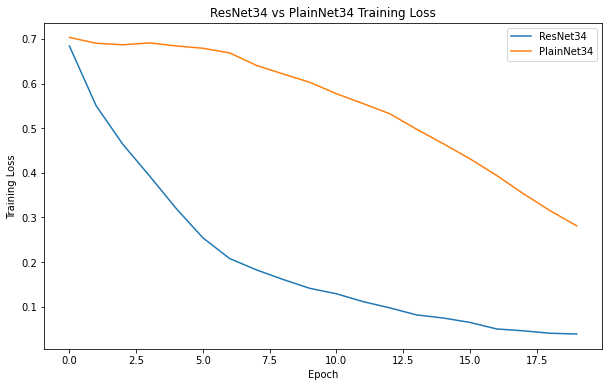

In [88]:
import matplotlib.pyplot as plt
# 34-레이어 모델의 학습 손실 비교
plt.figure(figsize=(10, 6))
plt.plot(history_dict['resnet34']['loss'], label='ResNet34')
plt.plot(history_dict['plainnet34']['loss'], label='PlainNet34')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('ResNet34 vs PlainNet34 Training Loss')
plt.legend()
plt.show()

### ResNet34 Model Training loss 비교 결과

#### 학습 손실 비교를 통해서는 ResNet이 학습이 더빠르게  진행되는 것을 확인할 수 있었다. 
#### 왜 이러한 결과가 나타날지? 
#### 단순히 skip connection을 사용하는 것만으로도 학습이 빠르게 진행되는 이유는 gradient vanishing문제와 관련이 있다. skip connection은 add 층에서 입력을 직접 연결하며, H(x)= F(x)+x로 표현된다. 잔차 연결은 역전파 과정에서 기울기(gradient)가 사라지지 않고 일정한 크기를 유지하도록 하여서 가중치 업데이트가 원활하게 이루어지도록 한다
#### 역전파 과정ㅇ에서 기울기가 계속 곱해져 손실은 최소화하는 과정에서 기울기가 매우 작은 값에 수렴하게 되는 문제가 발생한다. 이를 gradient vanishing 문제라고 하며, 결과적으로 많은 층에서 가중치 업데이트가 이루어지지 않아 학습 속도가 매우 느려지게 된다. 여기서 skip connection은 x의 미분값인 1이 더해져 가중치 업데이트에 영향을 주는 요인이 된다. 이 부분이 ResNet에서 skip connection이 핵심적인 역할을 한다.
#### skip connection은 입력 x에 출력을 직접 더해주어 역전파 시 기울기의 경로를 보존하고, gradient vanishing을 방지한다. 따라서 더 깊은 네트워크에서도 학습이 원활하게 진행될 수 있도록 함과 동시에 학습 속도에도 영향을 준다.

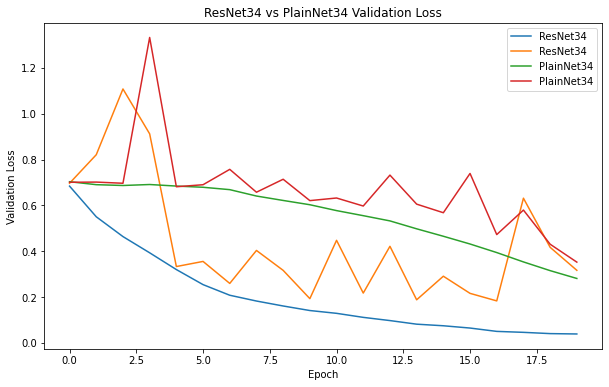

In [96]:
# 34-레이어 모델의 손실 비교
plt.figure(figsize=(10, 6))
plt.plot(history_dict['resnet34']['loss'], label='ResNet34')
plt.plot(history_dict['resnet34']['val_loss'], label='ResNet34')
plt.plot(history_dict['plainnet34']['loss'], label='PlainNet34')
plt.plot(history_dict['plainnet34']['val_loss'], label='PlainNet34')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet34 vs PlainNet34 Loss')
plt.legend()
plt.show()

### ResNet34 vs Plain34 Model Training-Validation Loss 비교 결과

#### 검증 손실을 비교했을 때, ResNet이 더 안정적인 학습을 유지하는 것을 확인할 수 있다. 또한 val_loss값이 더 작았다.
#### 왜 이러한 결과가 나타났을까?
#### Plain net 비교해서 더욱 안정적인 학습이 가능하다는 것을 직관적으로 확인할 수 있는 그래프가 확인되었다. ResNet은 학습손실이 꾸준히 감소하고 검증손실 또한 어느정도 안정화되면서 좋은 성능을 보여준다. 이는 skip connection이 gradient vanishing을 해결하여 좋은 성능을 보여준다는 것을 확인할 수 있음과 동시에 gradient vanishing의 문제로 인한 더딘 학습 속도를 개선하는 경우까지 확인이 가능하다. 

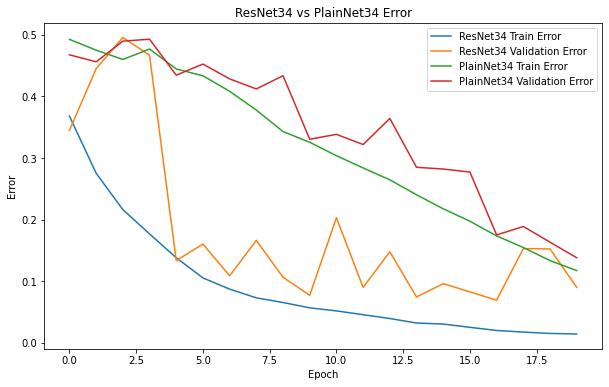

In [102]:
# 34-레이어 모델의 정확도 비교
plt.figure(figsize=(10, 6))
plt.plot(1 - np.array(history_dict['resnet34']['accuracy']), label='ResNet34 Train Error')
plt.plot(1 - np.array(history_dict['resnet34']['val_accuracy']), label='ResNet34 Validation Error')
plt.plot(1 - np.array(history_dict['plainnet34']['accuracy']), label='PlainNet34 Train Error')
plt.plot(1 - np.array(history_dict['plainnet34']['val_accuracy']), label='PlainNet34 Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('ResNet34 vs PlainNet34 Error')
plt.legend()
plt.show()

### ResNet34 vs Plain34 Model Training-Validation Error 비교 결과

#### 1-acc를 통해 Error를 계산하였다. 결과는 더욱 안정적인 학습이 가능하다는 것을 확인가능하다. (이유는 위에서 설명하므로 생략)

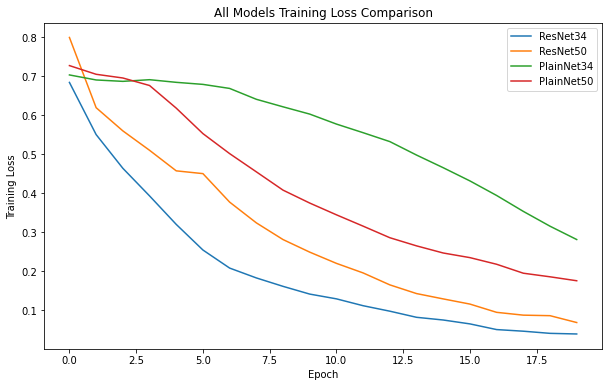

In [97]:
# 모든 모델의 학습 손실 비교
plt.figure(figsize=(10, 6))
plt.plot(history_dict['resnet34']['loss'], label='ResNet34')
plt.plot(history_dict['resnet50']['loss'], label='ResNet50')
plt.plot(history_dict['plainnet34']['loss'], label='PlainNet34')
plt.plot(history_dict['plainnet50']['loss'], label='PlainNet50')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('All Models Training Loss Comparison')
plt.legend()
plt.show()

#### 아직 plainNet의 최적화 지점을 찾지 못했다... 비교 실험에 대한 결과를 정확하게 얻을 수 없으나 어느 정도 확인은 가능하다.

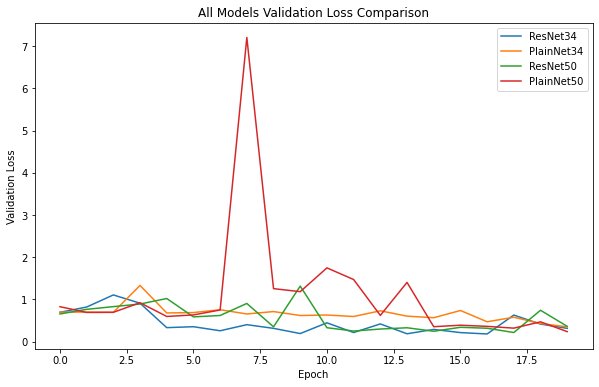

In [93]:
# 모든 모델의 학습 손실 비교
plt.figure(figsize=(10, 6))
plt.plot(history_dict['resnet34']['val_loss'], label='ResNet34')
plt.plot(history_dict['plainnet34']['val_loss'], label='PlainNet34')
plt.plot(history_dict['resnet50']['val_loss'], label='ResNet50')
plt.plot(history_dict['plainnet50']['val_loss'], label='PlainNet50')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('All Models Validation Loss Comparison')
plt.legend()
plt.show()

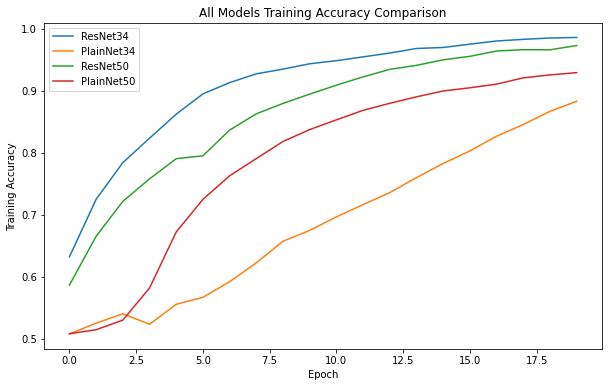

In [94]:
# 모든 모델의 학습 손실 비교
plt.figure(figsize=(10, 6))
plt.plot(history_dict['resnet34']['accuracy'], label='ResNet34')
plt.plot(history_dict['plainnet34']['accuracy'], label='PlainNet34')
plt.plot(history_dict['resnet50']['accuracy'], label='ResNet50')
plt.plot(history_dict['plainnet50']['accuracy'], label='PlainNet50')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('All Models Training Accuracy Comparison')
plt.legend()
plt.show()

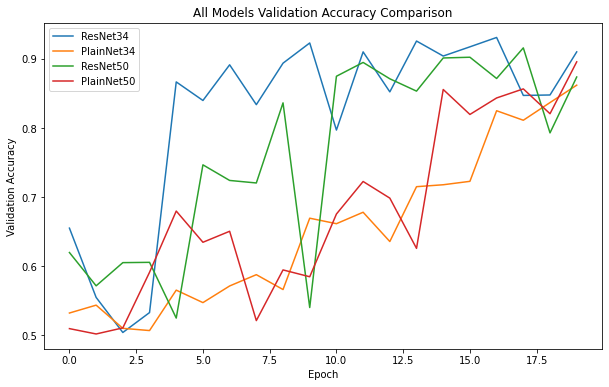

In [95]:
# 모든 모델의 학습 손실 비교
plt.figure(figsize=(10, 6))
plt.plot(history_dict['resnet34']['val_accuracy'], label='ResNet34')
plt.plot(history_dict['plainnet34']['val_accuracy'], label='PlainNet34')
plt.plot(history_dict['resnet50']['val_accuracy'], label='ResNet50')
plt.plot(history_dict['plainnet50']['val_accuracy'], label='PlainNet50')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('All Models Validation Accuracy Comparison')
plt.legend()
plt.show()

## 회고 및 알게된점 : Ablation study...쉽지않다..

### 정당한 비교란 ? 
#### 모델의 Epochs를 동일하게 한다고 정당한 비교라고 할 수 없다. 모델에 따라서 epoch 수는 달라지는 것이 당연하다. 각 모델당 최적화된 지점을 찾았을 때 그 지점에서의 비교가 오히려 정당한 비교가 될수 있다. 모델에 따라 학습이 필요한 반복수는 다르기 때문에... training loss와 val_loss를 비교하여 val_loss가 높아지는 지점을 과대적합이 된 상태이므로 그 전 지점이 최적 적합 지점에서의 모델 성능 비교를 진행하는 것이 비로서 정당한 비교가 되겠다...
